## The NLP part

In [1]:
from tqdm import tqdm
import numpy as np
import pickle
import os
import time
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
import re
from collections import Counter

### Load the data

In [2]:
import json
with open('classic_poems.json') as f:
    data_json = json.load(f)


In [3]:
strof_len = 8
data = []
content = []
labels = []
for row in data_json:
    cont, poet = row['content'].split('\n'), row['poet_id']
    while len(cont)>strof_len:
        poem = '\n'.join(cont[:strof_len])
        data.append([poem, poet])
        content.append(poem)
        labels.append(poet)
        cont = cont[strof_len:]

In [4]:
len(data)

7992

In [5]:
print(data[-4][0][:500])

пряха всех своим сукном.
Встанут стройно фабрик трубы,
ткани будут все тонки́,
и не станут сукон грубых
вырабатывать станки.
А пока, —
          чтоб то случилось,
что сияет впереди,


### Dictionary

In [6]:
def clean(sent):
    """
    убираем все знаки кроме киррилицы цифр, ,.?!
    """   

    reg = re.compile('[^а-яА-Я|!?,.\n\u2003 ]')
    sent = reg.sub('', sent).lower()
    sent = re.findall(r"[\w']+|[!?,.\n\u2003]", sent)
    return sent
    
def get_c2i(counter, min_occurrence, add):
    """ делаем словарь из Countrer"""

    
    if add:
        w2ind = {k: i + 1 for i, (k, v) in enumerate(counter.most_common()) if v >= min_occurrence}
        w2ind["PADDING_TOKEN"] = 0
        w2ind["UNKNOWN_TOKEN"] = len(w2ind)
        w2ind["START_TOKEN"] = len(w2ind)
        w2ind["END_TOKEN"] = len(w2ind)
    else:
        w2ind = {k: i for i, (k, v) in enumerate(counter.most_common()) if v >= min_occurrence}

    ind2w = {v: k for k, v in w2ind.items()}
    return w2ind, ind2w


def get_uni2idx(text, min_occurrence=3, add=True):
    """ Словарь униграмм"""
    
    unigrams_counter = Counter()  
    for t in tqdm(text):
        unigrams_counter.update(t)

    w2ind, ind2w = get_c2i(unigrams_counter, min_occurrence=min_occurrence, add=add)
    print('length of unigram dictionary: ', len(w2ind))

    return w2ind, ind2w, unigrams_counter

In [7]:
with Pool(50) as p:
    content = p.map(clean, content)

In [8]:
uni2idx, inx2uni, uni_counter = get_uni2idx(content, 3)

100%|██████████| 7992/7992 [00:00<00:00, 96966.91it/s]

length of unigram dictionary:  12806


In [9]:
lab2idx, inx2lab, lab_counter = get_uni2idx([labels], 3, add=False)

100%|██████████| 1/1 [00:00<00:00, 802.58it/s]

length of unigram dictionary:  5


In [10]:
lab2idx

{'blok': 1, 'esenin': 3, 'mayakovskij': 2, 'pushkin': 0, 'tyutchev': 4}

## Building the dataset 

In [11]:
def vectorize_data(data, uni2idx, lab2idx):
    """Возвращает векторизованные данные."""
    
    word_indices = []
    
    sentence, label = data
    
    sentence = clean(sentence)

    word_indices.append(uni2idx["START_TOKEN"])
    
    for pos_in_padded_sentence, word in enumerate(sentence):
            
        word_idx = get_token_indices(word, uni2idx, uni2idx['UNKNOWN_TOKEN'])
        word_indices.append(word_idx)
        
    word_indices.append(uni2idx["END_TOKEN"])   
    dataset = [word_indices, lab2idx[label]]

    return dataset

def get_token_indices(token, uni2idx, uni_unknown_index):

    return uni2idx.get(token, uni_unknown_index)

In [25]:
print('Vectorizing...')

def vectorize(x):
    return vectorize_data(x, uni2idx, lab2idx)

with Pool(10) as p:
    data_vectorized = p.map(vectorize, data)


print('Splitting the data into train and evaluate...')
X_tr, X_ev = train_test_split(
                              data_vectorized,
                              test_size=0.1,
                              random_state=24)


Vectorizing...
Splitting the data into train and evaluate...


In [26]:
poem_lengths = np.array(list(map(lambda x: len(x[0]), X_tr)))
poem_lengths.mean(), poem_lengths.max(), poem_lengths.min()

(51.217602892102335, 95, 11)

## Building the model

In [27]:
EMB_DIM = 100
N_LAYERS = 2
HID_EMB = 100
NUM_CLASSES = len(lab2idx)
LR = 1e-3

In [28]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Encoder(nn.Module):
    def __init__(self):
        """ 
        A simple encoder for poem.
        
        output two vectors, one is responsoble for the style (author), the other - for the meaning
        """
        super(self.__class__, self).__init__()
        
        self.emb = nn.Embedding(len(uni2idx), EMB_DIM, padding_idx=uni2idx['PADDING_TOKEN'])
        self.rnn = nn.GRU(EMB_DIM, HID_EMB, N_LAYERS, batch_first=True)
        self.style = nn.Linear(HID_EMB, HID_EMB)
        self.meaning = nn.Linear(HID_EMB, HID_EMB)
        
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: 
            tuple( [batch_size, seq_len, hid_size], [batch_size, seq_len, hid_size])
        """
        emb = self.emb(text_ix)
#         print('emb', emb.shape)
        hid, _ = self.rnn(emb)
#         print('hid', hid.shape)

        return self.style(hid), self.meaning(hid)

In [29]:
class Discriminator(nn.Module):
    def __init__(self):
        """ 
        Trying to distinguish between styles based on the input vector
        
        """
        super(self.__class__, self).__init__()            
        self.l1 = nn.Linear(HID_EMB, HID_EMB//2)
        self.logits = nn.Linear(HID_EMB//2, NUM_CLASSES)
        
    def forward(self, emb):
        """
        :param emb: [batch_size, HID_EMB]
        :returns:  [batch_size, NUM_CLASSES]
        """
        emb = emb.mean(1)
        emb_l1 = F.relu(self.l1(emb))
        out = self.logits(emb_l1)
#         print('Discriminator out', out.shape)
        return out

class Motivator(nn.Module):
    def __init__(self):
        """ 
        Trying to distinguish between styles based on the input vector
        """
        super(self.__class__, self).__init__()
        self.m = Discriminator()
        
    def forward(self, emb):
        """
        :param emb: [batch_size, HID_EMB]
        :returns: [batch_size, NUM_CLASSES]
        """
        out = self.m(emb)
#         print('Motivator out', out.shape)
        return out

In [30]:
class Generator(nn.Module):
    def __init__(self,):
        """ 
        A sequential decoder.
        """
        super(self.__class__, self).__init__()
        
        self.rnn = nn.GRU(2*HID_EMB, 2*HID_EMB, N_LAYERS, batch_first=True)
        self.logits = nn.Linear(2*HID_EMB, len(uni2idx))
        
    def forward(self, emb_style, emb_meaning):
        """
        :param text_ix: tuple( [batch_size, seq_len, hid_size], [batch_size, seq_len, hid_size])
        :returns: [batch_size, tokens]
        """
        
        emb = torch.cat([emb_style, emb_meaning], dim=-1)
        hid, _ = self.rnn(emb)
        logits = self.logits(hid)
#         print('Decoder logits', logits.shape)
        return logits

### Losses

In [31]:
g_criterion = nn.CrossEntropyLoss(ignore_index = uni2idx['PADDING_TOKEN'])  
m_criterion = nn.CrossEntropyLoss() 
d_criterion = nn.CrossEntropyLoss() 

def m_loss(logits, labels):

    loss = m_criterion(logits, labels)
    
    return  loss 

def d_loss(logits, labels):
      
    loss = d_criterion(logits, labels)
        
    return  loss 

def g_loss(logits, poem):

    poem_next = poem[:, 1:].contiguous()
     
    loss = g_criterion(logits.view(-1, len(uni2idx)) , poem_next.view(-1)) 
        
    return  loss 

### optimazers 

In [32]:
encoder = Encoder()
discriminator = Discriminator()
motivator = Motivator()
generator = Generator()


from itertools import chain
from torch import optim

g_optimizer = optim.Adam(chain(encoder.parameters(),
                             generator.parameters()),  lr=LR, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
m_optimizer = optim.Adam(motivator.parameters(), lr=LR, betas=(0.5, 0.999))

## Training loop

In [33]:
from keras.preprocessing.sequence import pad_sequences

def pad_batch(sequences, max_len=None, global_max=500, pad_index = uni2idx['PADDING_TOKEN']):
    """ pad batch with max len """
    
    max_len = max_len or max(map(len,sequences))    
    max_len = min(global_max, max_len)
    
#     print(len(sequences))
    sequences = pad_sequences(sequences, maxlen=max_len,  padding='post', value=pad_index)
#     print(len(sequences))
#     print('sequences', len(sequences[0]))

    return sequences

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [34]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        poems = [data[i][0] for i in indices[start : start + batch_size]]
        poems = pad_batch(poems)
        labels = [data[i][1] for i in indices[start : start + batch_size]]
        
        yield Variable(torch.LongTensor(poems)), \
                       Variable(torch.LongTensor(labels))
                       

In [35]:
n_epochs = 2
n_batches_per_epoch = len(X_tr)
n_validation_batches = len(X_ev)

In [36]:
from IPython import display
import math

def train(X_tr, X_ev, batch_size=3, n_epochs=3, verbose=True):
    """
    args:
        X_tr, X_te, y_tr, y_te: datasets
        batch_size: int
    returns:
        generator: model
        epoch: integer (the last epoch)
        history: dict
    """
    
    n_train_batches = math.ceil(len(X_tr) / batch_size)
    n_validation_batches = math.ceil(len(X_ev) / batch_size)

    history = {'generator_train_loss': [], 'generator_val_loss': [],
               'motivator_train_loss': [], 'motivator_val_loss': [], 'discriminator_train_loss': [], 
               'discriminator_val_loss': [], 'overall_train_loss': [], 'overall_val_loss': []}
    
    dis_loss_c, mot_loss_c, gen_loss_c, overall_loss_c = 0, 0, 0, 0

    try:
        for epoch in range(n_epochs):
            start_time = time.time()
            
            discriminator.train(True); motivator.train(True); 
            generator.train(True); encoder.train(True); 
            for poems, labels in iterate_minibatches(X_tr, batch_size):

                # encoding
                poem_inp = poems[:, :-1].contiguous()
                enc_style, enc_mean = encoder(poem_inp)  

                # discriminator step
                dis_loss = d_loss(discriminator(enc_mean), labels)
                d_optimizer.zero_grad()
                dis_loss.backward(retain_graph=True)
                d_optimizer.step()

                # motivator step
                mot_loss = m_loss(motivator(enc_style), labels)
                m_optimizer.zero_grad()
                mot_loss.backward(retain_graph=True)
                m_optimizer.step()

                #generator step
                gen_loss = g_loss(generator(enc_style, enc_mean), poems)
                overall_loss = gen_loss + mot_loss - dis_loss
                g_optimizer.zero_grad()
                overall_loss.backward()
                g_optimizer.step()
                
                dis_loss_c += dis_loss.cpu().data.numpy()
                mot_loss_c += mot_loss.cpu().data.numpy()
                gen_loss_c += gen_loss.cpu().data.numpy()
                overall_loss_c += overall_loss.cpu().data.numpy()
                
                
            history['generator_train_loss'].append(gen_loss_c/n_train_batches)
            history['motivator_train_loss'].append(mot_loss_c/n_train_batches)
            history['discriminator_train_loss'].append(dis_loss_c/n_train_batches)
            history['overall_train_loss'].append(overall_loss_c/n_train_batches)
            
            discriminator.train(False); motivator.train(False); 
            generator.train(False); encoder.train(False); 
            dis_loss_c, mot_loss_c, gen_loss_c, overall_loss_c = 0, 0, 0, 0
            for poems, labels in iterate_minibatches(X_ev, batch_size):

                # encoding
                poem_inp = poems[:, :-1].contiguous()
                enc_style, enc_mean = encoder(poem_inp)  

                # discriminator step
                dis_loss = d_loss(discriminator(enc_mean), labels)
                # motivator step
                mot_loss = m_loss(motivator(enc_style), labels)
                #generator step
                gen_loss = g_loss(generator(enc_style, enc_mean), poems)
                overall_loss = gen_loss + mot_loss - dis_loss
                
                dis_loss_c += dis_loss.cpu().data.numpy()
                mot_loss_c += mot_loss.cpu().data.numpy()
                gen_loss_c += gen_loss.cpu().data.numpy()
                overall_loss_c += overall_loss.cpu().data.numpy()
                
                
            history['generator_val_loss'].append(gen_loss_c/n_validation_batches)
            history['motivator_val_loss'].append(mot_loss_c/n_validation_batches)
            history['discriminator_val_loss'].append(dis_loss_c/n_validation_batches)
            history['overall_val_loss'].append(overall_loss_c/n_validation_batches)
            
            # Visualize
            if verbose:
                display.clear_output(wait=True)
                plt.figure(figsize=(16, 6))
                # Then we print the results for this epoch:
                print("Epoch {} of {} took {:.3f}s".format(
                    epoch + 1, n_epochs, time.time() - start_time))
                print('current overall train loss: {}'.format(history['overall_train_loss'][-1]))
                print('current overall val loss: {}'.format(history['overall_val_loss'][-1]))
                plot_history(history)

    except KeyboardInterrupt:
        return  epoch, history

    print("Finished!")
       
    return  epoch, history

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    plt.subplot(221)
    plt.title("generator")
    plt.ylabel("loss")
    plt.plot(history['generator_train_loss'], 'b', label='train_loss')
    plt.plot(history['generator_val_loss'], 'g', label='val_loss')
    plt.legend()
    plt.subplot(222)
    plt.title("motivator")
    plt.ylabel("loss")
    plt.plot(history['motivator_train_loss'], label="train_loss")
    plt.plot(history['motivator_val_loss'], label="val_loss")
    plt.legend()
    plt.subplot(223)
    plt.title("discriminator")
    plt.xlabel("#epoch")
    plt.ylabel("loss")
    plt.plot(history['discriminator_train_loss'], label="train_loss")
    plt.plot(history['discriminator_val_loss'], label="val_loss")
    plt.legend()
    plt.subplot(224)
    plt.title("overall")
    plt.xlabel("#epoch")
    plt.ylabel("loss")
    plt.plot(history['overall_train_loss'], label="train_loss")
    plt.plot(history['overall_val_loss'], label="val_loss")
    plt.legend()
    plt.show()

Epoch 2 of 3 took 451.152s
current overall train loss: 5.297302326269909
current overall val loss: 4.838706566737248


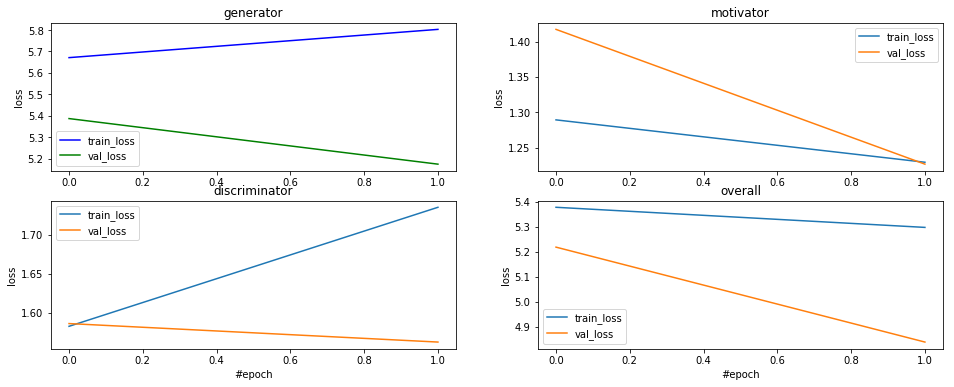

HBox(children=(IntProgress(value=0, max=113), HTML(value='')))

In [37]:
epoch, history = train(X_tr, X_ev, batch_size=64, n_epochs=3)

## Generating some masterpieces

### Finding style embeddings  for the authors

In [38]:
def find_embeddings(data, size=5, max_len=100):
    """ищем эбеддинги стиля для каждого автора"""

    embeddings = {key:[] for key in lab2idx.keys()}    
    labels = np.array([data[i][-1] for i in range(len(data))])
    
    for key in embeddings.keys():
        
        indices = np.where(lab2idx[key]==labels)[0]      
        indices = np.random.choice(indices, size=size) 
        
        data_author = pad_batch([data[i][0] for i in indices], max_len=max_len)
        poems = Variable(torch.LongTensor(data_author), volatile=True)      
        poem_inp = poems[:, :-1].contiguous()
        
        emb_style, emb_meaning = encoder.forward(poem_inp)       
        embeddings[key] = emb_style
    
    return embeddings

In [39]:
embeddings = find_embeddings(X_tr)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


In [40]:
embeddings['blok'].shape

torch.Size([5, 99, 100])

In [45]:
def generate_poem(prefix_ix = uni2idx["START_TOKEN"], 
                     t=1, sample=True, max_len=100, author = None, meaning = None):
    
    """генирим произведения по автору, если автор не задан - используется эмбеддинг стиля из энкодера"""

    poem_prefix = [prefix_ix]
    
    if meaning is not None:
        mean, _ = list(map(vectorize, [[meaning, 'pushkin']]))[0]        
        poem_prefix = mean[:-1]
    
    phrase = []
    for _ in range(max_len-1):
        
        prefix_ix = [poem_prefix]
        
        prefix_ix = Variable(torch.LongTensor(prefix_ix), volatile=True)

        emb_style, emb_meaning = encoder.forward(prefix_ix)

        if author is not None:
            emb_style = embeddings[author][:, :len(poem_prefix)].mean(0, keepdim=True)
            
        next_word_logits = generator.forward(emb_style, emb_meaning)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).cpu().data.numpy()
        
        assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            while True:
                next_word_ind = np.random.choice(len(uni2idx), p=next_word_probs) 
                if next_word_ind != uni2idx['UNKNOWN_TOKEN']: # выбираем пока не выверем что-то отличное от неизвестного символа
                    break
        else:
            next_word_probs[uni2idx['UNKNOWN_TOKEN']]=0 # зануляем вероятность неизвестного символа
            next_word_ind = np.argmax(next_word_probs)

        poem_prefix.append(next_word_ind)

        next_word = inx2uni[next_word_ind]
        phrase.append(next_word)

        if next_word_ind==uni2idx["END_TOKEN"]:
            break
            
    return ' '+' '.join(phrase[:-1])

In [46]:
# phrase = generate_caption(sample=True, author = 'blok')

In [47]:
for author in embeddings.keys():
    print(author+': \n')
    print(' '+'*'*5)
    phrase = generate_poem(sample=True, author = author, t=1, meaning = 'Любовь спасет мир') 
    print(phrase)
    print()
    

pushkin: 

 *****


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


 
 попал , теперь спасибо за и цветы миром 
 уголь белея брат к вина 
 и сводом не великий ! но крепкий в пушкин 
 же разгорались , жребий ,

blok: 

 *****
 бы 
 птицей по голубоватый соберу . к весны монах я ты по растет ! руками когда радугой 
 , шептались альбом когдато . 
 что зефир любви расстаться вывеской жертв 
 никто ней , , . 
 и пою под трус . . б , , любви со 
 мною 
 
 холодной и   чистый с темноты . , . , нет , . . как 
 , мою , 
 
 , не крест   
 послал под .

mayakovskij: 

 *****
 , 
 меди смесь и нет она каждый , , 
 краев тоскует голубая я молодость крыльцо тобою , ? 
 на и дух я же домам , 
 земля песню точит 
 навек . 
 как книги ива скоро 
 ныне       мщенья за , моим . 
 и меж 
       мы 
               воротах народу труб 
 что , 
 а 
 из . умирать украдкой

esenin: 

 *****
 франции . 
 небе деревне неси , быть , веселой туманной свет надписи 
 вурдалак или на здравствует 
 ни удара звездою , 
 ах бы вот , 
 вас пали на ладьи в 
 . в наслаждений стал утренний 